In [6]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

데이터 load, 시트간 merge

In [7]:
data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='야드크레이인_작업이력')
scd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='반출입_예정컨테이너')
cbd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_전')
cad_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_후')
quay_work_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='본선크레인_작업이력')

# int 타입임
print(quay_work_data['작업완료시간'].dtype)
quay_work_data['작업완료시간'] = quay_work_data['작업완료시간'].astype(str).replace('^2020', '2023', regex=True)
print(quay_work_data.shape)
merge_list = []
# data, container_before_data, container_after_data merge
ycb_common_values = data['컨테이너번호'].isin(quay_work_data['컨테이너번호']).sum() # 6103개
print('ycb_common_values', ycb_common_values)
# data_quay_work_common_df = pd.merge(data, quay_work_data, on='컨테이너번호')
# data_scd_work_common_df = pd.merge(data, scd_data, on='컨테이너번호')
data_cad_data_common_df = pd.merge(data, cad_data, on='컨테이너번호')
# merge_list.append(data_quay_work_common_df)
# merge_list.append(data_scd_work_common_df)
# merge_list.append(data_cad_data_common_df)

common_df = data_cad_data_common_df
print(common_df.shape)

int64
(2744, 14)
ycb_common_values 3212
(6103, 40)


데이터 전처리(날짜 - datetime, 문자열 - 숫자)

In [8]:
# data_after merge
common_df['작업코드'] = common_df['작업코드'].replace({'VU': 1, 'VL': 2, 'GR': 3, 'GD': 4, 'TM':5,'TS':6})
common_df['장비번호'] = common_df['장비번호'].replace({'Y02': 1})
common_df['풀(F)공(M)'] = common_df['풀(F)공(M)'].replace({'M':1, 'F':2})
common_df['수출/수입'] = common_df['수출/수입'].replace({'X':1,'I':2,'S':3,'M':4})
    
#시간 타입 통합
common_df['작업생성시간'] = pd.to_datetime(common_df['작업생성시간'], format='%Y%m%d%H%M%S')
common_df['작업완료시간'] = pd.to_datetime(common_df['작업완료시간'], format='%Y%m%d%H%M%S')

# 외부트럭에 1 넣기
common_df['야드트럭(번호)'] = common_df['야드트럭(번호)'].fillna(1)
print('common_df',common_df)
print('작업생성시간',common_df['작업생성시간'].dtype)
print('작업완료시간',common_df['작업완료시간'].dtype)

common_df['작업+대기시간'] = common_df['작업완료시간'] -common_df['작업생성시간']
print(common_df[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간']])
print(common_df['작업+대기시간'].isna().sum())
print('common_df',common_df.info())
# common_df = common_df[-1000:]
print(common_df.shape)

common_df            컨테이너번호  작업코드 선박코드_x  년도_x  항차_x 블록_x  베이_x  로우_x  티어_x 블록2  ...   
0     CKJN9049578     1   HHTK  2023    19   7E   6.0   NaN   NaN  7E  ...  \
1     HCWX3125579     1   PCHM  2023     4   4R  27.0   NaN   NaN  4R  ...   
2     LMEC0254366     1   MXMR  2023    16   4L   3.0   NaN   NaN  4L  ...   
3     WIQF7935938     1   CAET  2023    11   1A  12.0   NaN   NaN  1A  ...   
4     WIQF7935938     6   CAET  2023    11   1A  12.0   3.0   3.0  1A  ...   
...           ...   ...    ...   ...   ...  ...   ...   ...   ...  ..  ...   
6098  FRKE6756314     3   HAKT  2023     2   4D  15.0   NaN   NaN  4D  ...   
6099  JPPT1528912     6   PCHM  2023     4   7A  13.0   8.0   4.0  7A  ...   
6100  GZEH5361207     6   KMDF  2023     3   3R  14.0   1.0   2.0  3R  ...   
6101  VNCL0771568     1   DJVS  2023    12   3H   3.0   NaN   NaN  3H  ...   
6102  ONCF8625600     6   MIBH  2023     7   8A   9.0   5.0   3.0  8A  ...   

      목적지(코드)  블록_y  베이_y  로우_y 티어_y  수출/수입  Unnamed:

데이터 상관관계 분석

(2000, 41)
(4103, 41)


d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


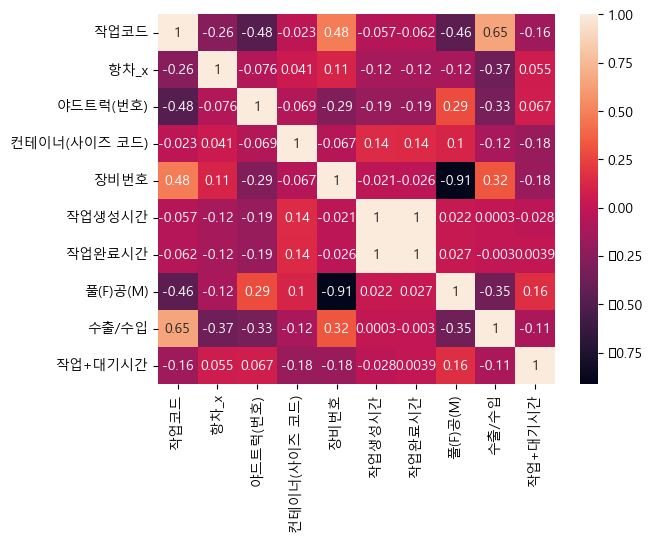

In [9]:
# data, quay merge
common_df_truck_out = common_df[common_df['야드트럭(번호)'] != 1]
print(common_df_truck_out.shape)
common_df_truck_in = common_df[common_df['야드트럭(번호)'] == 1]
print(common_df_truck_in.shape)
correlation_matrix = common_df_truck_out[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간', '풀(F)공(M)', '수출/수입','작업+대기시간']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

정규분포 그래프

0      0 days 00:07:13
1      0 days 00:06:21
2      0 days 00:09:29
3      0 days 00:04:43
5      0 days 00:05:00
             ...      
6087   0 days 00:22:17
6090   0 days 00:05:00
6091   0 days 00:05:00
6096   0 days 00:22:22
6101   0 days 00:21:38
Name: 작업+대기시간, Length: 2000, dtype: timedelta64[ns]


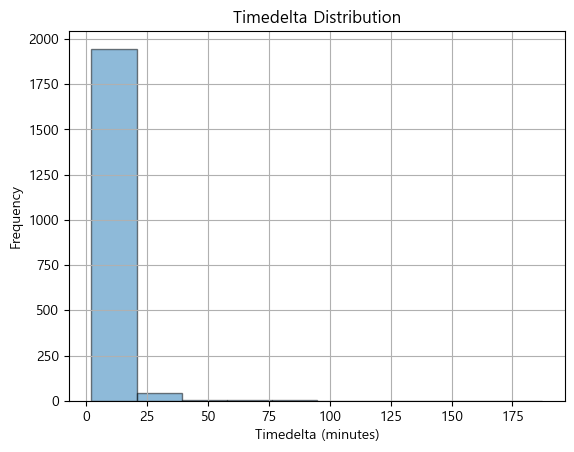

In [10]:
data = common_df_truck_out['작업+대기시간']
print(data)
# Timedelta 값을 숫자 값으로 변환
data = data.dt.total_seconds() / 60  # timedelta 값을 분으로 변환

# 정규분포 그래프 그리기
plt.hist(data, bins=10, edgecolor='black', alpha=0.5)
plt.xlabel('Timedelta (minutes)')
plt.ylabel('Frequency')
plt.title('Timedelta Distribution')
plt.grid(True)
plt.show()

모델 학습 전 추가 전처리

In [27]:
common_df2 = common_df
common_df2['풀(F)공(M)'] = common_df2['풀(F)공(M)'].astype('int64')
common_df2 = common_df2.dropna(subset=['작업+대기시간'])

# 작업생성시간을 Unix timestamp로 변환
common_df2['작업생성시간'] = common_df2['작업생성시간'].astype('int64') // 10**9
common_df2['작업+대기시간'] = common_df2['작업+대기시간'].dt.total_seconds() /60.0

common_df2['풀(F)공(M)'] = common_df2['풀(F)공(M)'].astype('int64')
common_df2 = common_df2.dropna(subset=['작업+대기시간'])
common_df_complete = common_df2

C:\Users\SW\AppData\Local\Temp\ipykernel_8024\347278900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df2['작업생성시간'] = common_df2['작업생성시간'].astype('int64') // 10**9
C:\Users\SW\AppData\Local\Temp\ipykernel_8024\347278900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df2['작업+대기시간'] = common_df2['작업+대기시간'].dt.total_seconds() /60.0
C:\Users\SW\AppData\Local\Temp\ipykernel_8024\347278900.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

CNN 모델 학습

Epoch 1/10
153/153 [==============================] - 1s 2ms/step - loss: 109.4762 - val_loss: 113.0720
Epoch 2/10
153/153 [==============================] - 0s 1ms/step - loss: 86.8733 - val_loss: 106.9980
Epoch 3/10
153/153 [==============================] - 0s 1ms/step - loss: 81.5263 - val_loss: 101.8098
Epoch 4/10
153/153 [==============================] - 0s 1ms/step - loss: 76.3187 - val_loss: 96.6616
Epoch 5/10
153/153 [==============================] - 0s 1ms/step - loss: 73.2653 - val_loss: 94.7227
Epoch 6/10
153/153 [==============================] - 0s 1ms/step - loss: 71.8735 - val_loss: 93.2624
Epoch 7/10
153/153 [==============================] - 0s 1ms/step - loss: 71.4588 - val_loss: 92.6372
Epoch 8/10
153/153 [==============================] - 0s 1ms/step - loss: 70.6096 - val_loss: 92.7959
Epoch 9/10
153/153 [==============================] - 0s 1ms/step - loss: 70.5036 - val_loss: 91.9979
Epoch 10/10
39/39 [==============================] - 0s 682us/step
실제값: 5.0 예측

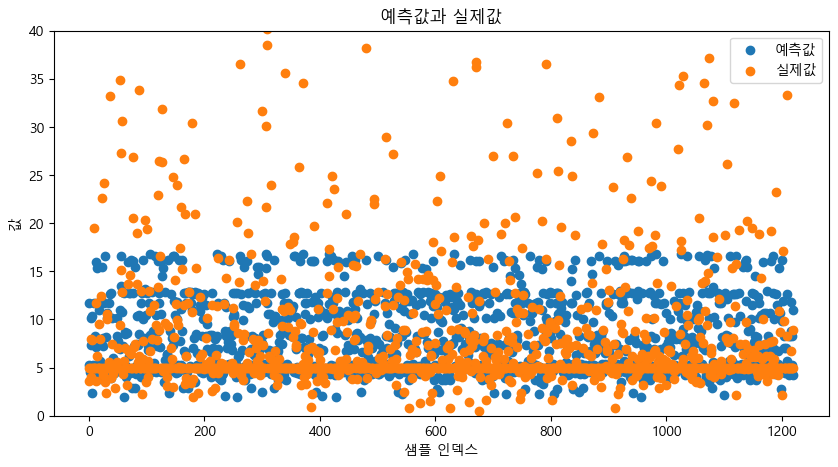

In [28]:
# common_df_complete = common_df_complete[-700:]
X = common_df_complete[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '풀(F)공(M)', '수출/수입']]
y = common_df_complete['작업+대기시간']

# 데이터 전처리
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# CNN 모델 구성
model = Sequential()
# 합성곱(Conv1D) 레이어
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
# 풀링(MaxPooling1D) 레이어
model.add(MaxPooling1D(2))
model.add(Flatten())
# 완전연결(Dense) 레이어 활성화 함수(relu)
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 훈련
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 예측
predictions = model.predict(X_test)

# 결과 출력
for i in range(len(predictions)):
    print('실제값:', y_test.values[i], '예측값:', predictions[i][0])


# 그래프 설정
# 모델 예측
predictions = model.predict(X_test)

# 그래프 설정
plt.figure(figsize=(10, 5))
plt.scatter(range(len(predictions)), predictions, label='예측값')
plt.scatter(range(len(y_test)), y_test, label='실제값')
plt.xlabel('샘플 인덱스')
plt.ylabel('값')
plt.title('예측값과 실제값')
plt.ylim(0, 40)  # y축 범위 설정
plt.legend()
plt.show()

평가 지표

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 평가 지표 계산
# # 실제값과 예측값의 차이 계산
# errors = y_test - predictions

# # 평균 오차 계산
# mean_error = np.mean(errors)
# print(mean_error)
# # 평균 절대 오차 계산
# mean_absolute_error = np.mean(np.abs(errors))
# print(mean_absolute_error)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# 평가 지표 출력
print('평균 절대 오차 (MAE):', mae)
print('평균 제곱근 오차 (RMSE):', rmse)
print('평균 제곱 오차 (MSE):', mse)
print('결정 계수 (R^2):', r2)

평균 절대 오차 (MAE): 4.487124357788478
평균 제곱근 오차 (RMSE): 9.572746088647145
평균 제곱 오차 (MSE): 91.63746767770922
결정 계수 (R^2): 0.16025223197433125
